In [1]:
!wget -nc http://nlp.stanford.edu/data/glove.6B.zip

--2021-02-28 13:28:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-28 13:28:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-28 13:28:49--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [2]:
!unzip -n glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
import itertools
import nltk
import torch
import torch.nn as nn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
train_path = "/content/drive/MyDrive/anlp_final/snli_1.0_train.csv"
df = pd.read_csv(train_path, nrows= 10000)
df.head()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
3,neutral,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling and waving at camera,They are smiling at their parents,2267923837.jpg#2,2267923837.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
4,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN


In [4]:
df = df[['sentence1', 'sentence2', 'gold_label']]
df.head()

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [5]:
df['gold_label'].value_counts()

entailment       3336
contradiction    3329
neutral          3323
-                  12
Name: gold_label, dtype: int64

In [6]:
def encode_label(df):
  df = df[['sentence1', 'sentence2', 'gold_label']]
  lb = LabelEncoder()
  df = df[(df['gold_label'] == 'neutral') | (df['gold_label'] == 'contradiction') | (df['gold_label'] == 'entailment')]
  df['labels'] = lb.fit_transform(df['gold_label'])
  classes_names = lb.classes_
  df.drop('gold_label', axis = 1,  inplace= True)
  return df, classes_names

In [7]:
df, classes_names = encode_label(df)

In [8]:
df.head()

,sentence1,sentence2,labels
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,2
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
3,Children smiling and waving at camera,They are smiling at their parents,2
4,Children smiling and waving at camera,There are children present,1


In [9]:
classes_names

array(['contradiction', 'entailment', 'neutral'], dtype=object)

In [10]:
df.shape

(9988, 3)

##Embedding Things

In [14]:
def Embedding_dict(path):
  emb_dct = {}
  with open(path) as f:
    for line in f:
      word, coefs = line.split(maxsplit=1)
      coefs = np.fromstring(coefs, "f", sep=" ")
      emb_dct[word] = coefs
  print(f"Number of words found are {len(emb_dct)}")
  return emb_dct

In [13]:
def create_dataset(df, dct, func = 'sum', emb_dim = 300):
  embedding_matrix = np.zeros((df.shape[0], 2*emb_dim))
  hit = 0
  miss = 0
  for i, (s1, s2) in enumerate(zip(df['sentence1'], df['sentence2'])):
    vec1 = []
    vec2 = []
    s1 = s1.lower()
    s2 = s2.lower()
    s1 = word_tokenize(s1)
    s2 = word_tokenize(s2)
    for w1, w2 in list(itertools.zip_longest(s1, s2, fillvalue='foo')):
      if w1 != "foo":
        check1 = dct.get(w1)
        if check1 is not None:
          vec1.append(check1)
          hit+=1
        else:
          miss+=1
        
      if w2 != "foo":
        check1 = dct.get(w2)
        if check1 is not None:
          vec2.append(check1)
          hit+=1
        else:
          miss+=1
    ##
    vec1 = np.asarray(vec1)
    vec2 = np.asarray(vec2)
    if func == "sum":
      vec1 = np.sum(vec1, axis = 0)
      vec2 = np.sum(vec2, axis = 0)
    if func == "mean":
      vec1 = np.mean(vec1, axis = 0)
      vec2 = np.mean(vec2, axis = 0)
    #print("vec1 ", vec1.shape, "vec2 shape ", vec2.shape, "i is ", i)
    embedding_matrix[i, :] = np.concatenate((vec1, vec2))
  ##
  print(f"The number of hits are {hit} and the number of miss are {miss}")
  labels = df['labels'].values
  return embedding_matrix, labels    

In [ ]:
class simple_model(nn.Module):
  def __init__(self):
    super(simple_model, self).__init__()
    # self.embedding_matrix = embedding_matrix
    # self.labels = labels
    self.fc1 = nn.Linear(600, 256)
    self.fc2 = nn.Linear(256, 64)
    self.relu = nn.ReLU()
    self.fc3 = nn.Linear(64, 3)

  def forward(self, embedding_matrix):
    x = self.fc1(embedding_matrix)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x

In [ ]:
def train(model, embedding_matrix, labels, batch_size = 32, lr = 0.007, epochs = 4):
  model.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
  #model.zero_grad()
  for epoch in range(epochs):
    l = 0
    for i in range(embedding_matrix.shape[0]//batch_size):
      optimizer.zero_grad()
      inp = embedding_matrix[i*batch_size: (i*batch_size + batch_size), :]
      lab = torch.from_numpy(labels[i*batch_size: (i*batch_size + batch_size)])
      out = model(torch.from_numpy(inp).float())
      loss = criterion(out, lab)
      l += loss
      loss.backward()
      optimizer.step()

      
    if epoch%10 == 0:
      print("loss is ", loss)
      print(f"for epoch {epoch} loss is {l}")

In [ ]:
dct = Embedding_dict("/content/glove.6B.300d.txt")

Number of words found are 400000


In [ ]:
embedding_matrix, labels = create_dataset(df, dct)

The number of hits are 231113 and the number of miss are 550


In [ ]:
model = simple_model()

In [ ]:
train(model, embedding_matrix, labels, lr = 0.005, epochs = 500)

loss is  tensor(0.9782, grad_fn=<NllLossBackward>)
for epoch 0 loss is 316.9194641113281
loss is  tensor(0.8092, grad_fn=<NllLossBackward>)
for epoch 10 loss is 256.1901550292969


KeyboardInterrupt: ignored

In [ ]:
ypredt = model(torch.from_numpy(embedding_matrix).float())

In [ ]:
ypredt = torch.argmax(ypredt, dim = 1).numpy()

In [ ]:
labels

array([2, 1, 0, ..., 1, 0, 2])

In [ ]:
ypredt == labels

array([ True,  True,  True, ...,  True, False,  True])

In [ ]:
np.sum(ypredt == labels)/len(ypredt)

0.8984962406015038

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/anlp_final/snli_1.0_test.csv")
df_test, class_test = encode_label(df_test)

In [ ]:
df_test.head()

,sentence1,sentence2,labels
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,2
1,This church choir sings to the masses as they ...,The church is filled with song.,1
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,0
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,2
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,1


In [ ]:
xte, yte = create_dataset(df_test, dct)

The number of hits are 229983 and the number of miss are 598


In [ ]:
xte[:5,:]

array([[-5.13825274, -1.14646089, -2.48438668, ..., -1.49156785,
        -0.68954498,  0.13984601],
       [-5.13825274, -1.14646089, -2.48438668, ..., -0.68161893,
        -1.6593082 , -0.36632299],
       [-5.13825274, -1.14646089, -2.48438668, ..., -0.93746603,
        -1.24169397,  0.06316002],
       [-2.2857213 , -0.36229506,  0.77572596, ...,  0.1158911 ,
        -1.12795997,  0.78471696],
       [-2.2857213 , -0.36229506,  0.77572596, ..., -0.4090839 ,
        -0.66159904,  1.14149594]])

In [ ]:
xte = torch.from_numpy(xte).float()
yte =  torch.from_numpy(yte)

In [ ]:
ypred = model(xte)

In [ ]:
ypred[-10:,:]

tensor([[ 4.3126e+01,  7.0347e+01, -1.0076e+01],
        [-1.0572e+01,  2.7790e+01,  1.8030e+01],
        [-1.9625e+00,  5.8161e+00,  2.8308e+00],
        [ 9.4442e-02,  5.6617e-01, -8.0060e-01],
        [ 1.4751e+00,  1.1778e-01,  1.1701e+00],
        [ 3.4894e+01,  3.0397e+01, -6.7366e+00],
        [ 4.0253e+00,  5.8051e+00, -2.0695e+00],
        [ 2.6350e+02,  4.5084e+01,  8.0810e+01],
        [ 6.1699e+00,  1.8057e+01,  5.8050e+00],
        [-6.3174e+00, -2.1244e+01,  4.0846e+01]], grad_fn=<SliceBackward>)

In [ ]:
ypred = torch.argmax(ypred, dim = 1)

In [ ]:
ypred = ypred.numpy()

In [ ]:
yte = yte.numpy()

In [ ]:
np.sum(ypred == yte)/len(yte)

0.5315553745928339

## LSTM

In [19]:
def create_dataset_for_sequence(df, dct, emb_dim = 300, seq_len = 20):
  sequence_matrix = np.zeros((df.shape[0], seq_len*2 ,emb_dim))
  hit = 0
  miss = 0
  for i, (s1, s2) in enumerate(zip(df['sentence1'], df['sentence2'])):
    vec1 = np.zeros((seq_len, emb_dim))
    vec2 = np.zeros((seq_len, emb_dim))
    print(i)
    s1 = s1.lower()
    s2 = s2.lower()
    s1 = word_tokenize(s1)
    s2 = word_tokenize(s2)
    for j, (w1, w2) in enumerate(list(itertools.zip_longest(s1, s2, fillvalue='foo'))):
      if j>= seq_len:
        break
      if w1 != "foo":
        check1 = dct.get(w1)
        if check1 is not None:
          vec1[j, :] = check1
          hit+=1
        else:
          miss+=1
        
      if w2 != "foo":
        check1 = dct.get(w2)
        if check1 is not None:
          vec2[j, :] = check1
          hit+=1
        else:
          miss+=1

    sequence_matrix[i, :, :] = np.concatenate((vec1, vec2))
  ##
  print(f"The number of hits are {hit} and the number of miss are {miss}")
  labels = df['labels'].values
  return sequence_matrix, labels    

In [ ]:
class Mylstm(nn.Module):
  def __init__(self, batch_size, hidden_size, num_classes, num_layers, embedding_dim):
    super(Mylstm, self).__init__()
    self.batch_size = batch_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.embedding_dim = embedding_dim
    self.lstm = nn.LSTM(input_size= self.embedding_dim, hidden_size= self.hidden_size, num_layers = self.num_layers, batch_first = True)
    self.fc = nn.Linear(self.hidden_size, self.num_classes)
    

  # def forward(self, x):
  #   out, (self.h0, self.c0) = self.lstm(x, (self.h0, self.c0))
  #   out = self.fc(out[:,-1,:])
  #   return out


  def forward(self, x):
    out, (self.h0, self.c0) = self.lstm(x, (self.h0, self.c0))
    # out = out.contiguous().view(-1, self.hidden_size)
    tmp = out.clone()
    tmp = out[:, -1, :]
    #out = out[:,-1,:]
    #out = out.reshape(out.size(0)*out.size(1), out.size(2))
    out = self.fc(tmp)
    return out

  
  def init_hidden(self):
    self.h0 = torch.rand(1, self.batch_size, self.hidden_size)
    self.c0 = torch.rand(1, self.batch_size, self.hidden_size)


In [ ]:
def train_lstm(model, seq, labels, seq_val = None, labels_val = None, epochs = 10, lr = 0.005, batch_size = 461, hidden_size = 2):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr= lr)

  overall_loss = []
  for epoch in range(epochs):
    model.init_hidden()
    l = []
    for i in range(batch_size, seq.shape[0], batch_size):
      xtrain = seq[i-batch_size: i,:,:]
      target = labels[i-batch_size: i]
      model.train()
      out= model(xtrain)
      loss = criterion(out, target)
      optimizer.zero_grad()
      l.append(loss)
      loss.backward(retain_graph=True)
      optimizer.step()
      #print("LOSS : ", sum(l).item())
    print("This LOSS goes down : ", sum(l).item())

    if type(seq_val) != None:

      with torch.no_grad():
        for i in range(batch_size, seq.shape[0], batch_size):
          xtest = seq_val[i-batch_size: i,:,:]
          target_test = labels_val[i-batch_size: i]
          out_test = model(xtest)
          print("out test shape ", out_test.shape)
          print("labels shape ", target_test.shape)
          loss_test = criterion(out_test, target_test)
          print("validation loss ....")
          print(loss_test.item())

    # if epoch%10 == 0:
    #   print("loss is ", sum(l).item())
    # overall_loss += l

In [ ]:
## initializing variables

batch_size = 32
hidden_size = 128
num_classes = 3
num_layers = 1
embedding_dim = 300
lr = 0.005
epochs = 100

In [ ]:
# dct = Embedding_dict("/content/glove.6B.300d.txt")

Number of words found are 400000


In [ ]:
embedding_matrix, label = create_dataset_for_sequence(df, dct, emb_dim = embedding_dim)

The number of hits are 220037 and the number of miss are 514


In [ ]:
df_test = embedding_matrix[:100, :, :]
label_train = label[:100]

In [ ]:
df_val = embedding_matrix[100:200, :, :]
label_val = label[100:200]

In [ ]:
df_test = torch.tensor(df_test).float()
label = torch.tensor(label).type(torch.LongTensor)

In [ ]:
df_val = torch.tensor(df_val).float()
label_val = torch.tensor(label_val).type(torch.LongTensor)

In [ ]:
# df_test = torch.tensor(embedding_matrix).float()
# label = torch.tensor(label).type(torch.LongTensor)

In [ ]:
model = Mylstm(batch_size= batch_size, hidden_size= hidden_size, num_classes= num_classes, num_layers= num_layers, embedding_dim= embedding_dim)

In [ ]:
train_lstm(model, df_test, label_train, df_val, label_val, batch_size= batch_size, lr = 0.005, epochs= epochs)

## Keras

In [47]:
def Embedding_dict(path):
  emb_dct = {}
  with open(path) as f:
    for line in f:
      word, coefs = line.split(maxsplit=1)
      coefs = np.fromstring(coefs, "f", sep=" ")
      emb_dct[word] = coefs
  print(f"Number of words found are {len(emb_dct)}")
  return emb_dct

In [48]:
def create_dataset_for_sequence(df, dct, emb_dim = 300, seq_len = 20):
  sequence_matrix = np.zeros((df.shape[0], seq_len*2 ,emb_dim))
  hit = 0
  miss = 0
  for i, (s1, s2) in enumerate(zip(df['sentence1'], df['sentence2'])):
    vec1 = np.zeros((seq_len, emb_dim))
    vec2 = np.zeros((seq_len, emb_dim))
    if isinstance(s1, str) == False:
      continue
    if isinstance(s2, str) == False:
      continue
    s1 = s1.lower()
    s2 = s2.lower()
    s1 = word_tokenize(s1)
    s2 = word_tokenize(s2)
    for j, (w1, w2) in enumerate(list(itertools.zip_longest(s1, s2, fillvalue='foo'))):
      if j>= seq_len:
        break
      if w1 != "foo":
        check1 = dct.get(w1)
        if check1 is not None:
          vec1[j, :] = check1
          hit+=1
        else:
          miss+=1
        
      if w2 != "foo":
        check1 = dct.get(w2)
        if check1 is not None:
          vec2[j, :] = check1
          hit+=1
        else:
          miss+=1

    sequence_matrix[i, :, :] = np.concatenate((vec1, vec2))
  ##
  print(f"The number of hits are {hit} and the number of miss are {miss}")
  labels = df['labels'].values
  return sequence_matrix, labels    

In [103]:
## initializing variables

batch_size = 32
hidden_size = 128
num_classes = 3
num_layers = 1
embedding_dim = 300
lr = 0.005
epochs = 10
sentence_len = 20
epoch = 10
drop_out = 0.2

In [14]:
dct = Embedding_dict("/content/glove.6B.300d.txt")

Number of words found are 400000


In [85]:
embedding_matrix, label = create_dataset_for_sequence(df, dct, emb_dim = embedding_dim, seq_len= sentence_len)

The number of hits are 213651 and the number of miss are 462


In [86]:
embedding_matrix.shape

(9988, 40, 300)

In [52]:
from keras import Input
from keras.layers import Dense, LSTM, Dropout

In [90]:
inp = Input(shape = (sentence_len*2, embedding_dim))
lstm = LSTM(hidden_size)(inp)
#do = Dropout(drop_out)(lstm)
fc = Dense(num_classes)(lstm)
model = tf.keras.Model(inputs = inp, outputs = fc)

In [91]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 40, 300)]         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 387       
Total params: 220,035
Trainable params: 220,035
Non-trainable params: 0
_________________________________________________________________


#### Loading Validation Set

In [87]:
val_path = "/content/drive/MyDrive/anlp_final/snli_1.0_dev.csv"
df_val = pd.read_csv(val_path)

In [88]:
df_val, _ = encode_label(df_val)

In [89]:
val_matrix, val_label = create_dataset_for_sequence(df_val, dct)

The number of hits are 220037 and the number of miss are 514


#### Compiling the Model

In [92]:
model.compile(optimizer = 'Adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True), metrics = ['accuracy'])

In [93]:
model.fit(embedding_matrix, label, epochs= epoch, batch_size= batch_size, validation_data=(val_matrix, val_label))

Epoch 1/10
313/313 [==============================] - 33s 100ms/step - loss: 1.0513 - accuracy: 0.4307 - val_loss: 0.9453 - val_accuracy: 0.5484
Epoch 2/10
313/313 [==============================] - 31s 98ms/step - loss: 0.9107 - accuracy: 0.5765 - val_loss: 0.9117 - val_accuracy: 0.5719
Epoch 3/10
313/313 [==============================] - 31s 99ms/step - loss: 0.8531 - accuracy: 0.6095 - val_loss: 0.8994 - val_accuracy: 0.5806
Epoch 4/10
313/313 [==============================] - 34s 109ms/step - loss: 0.7992 - accuracy: 0.6390 - val_loss: 0.8900 - val_accuracy: 0.5947
Epoch 5/10
313/313 [==============================] - 31s 98ms/step - loss: 0.7406 - accuracy: 0.6746 - val_loss: 0.9039 - val_accuracy: 0.5894
Epoch 6/10
313/313 [==============================] - 31s 98ms/step - loss: 0.6838 - accuracy: 0.7118 - val_loss: 0.8939 - val_accuracy: 0.5964
Epoch 7/10
313/313 [==============================] - 31s 98ms/step - loss: 0.6349 - accuracy: 0.7381 - val_loss: 0.9145 - val_accurac

In [94]:
model.fit(embedding_matrix, label, epochs= epoch, batch_size= batch_size, validation_data=(val_matrix, val_label))

Epoch 1/10
313/313 [==============================] - 32s 101ms/step - loss: 0.3946 - accuracy: 0.8501 - val_loss: 1.1808 - val_accuracy: 0.5894
Epoch 2/10
313/313 [==============================] - 31s 98ms/step - loss: 0.3401 - accuracy: 0.8718 - val_loss: 1.2114 - val_accuracy: 0.5874
Epoch 3/10
313/313 [==============================] - 31s 101ms/step - loss: 0.2962 - accuracy: 0.8926 - val_loss: 1.4616 - val_accuracy: 0.5884
Epoch 4/10
313/313 [==============================] - 31s 98ms/step - loss: 0.2489 - accuracy: 0.9102 - val_loss: 1.3179 - val_accuracy: 0.5910
Epoch 5/10
313/313 [==============================] - 31s 99ms/step - loss: 0.2214 - accuracy: 0.9199 - val_loss: 1.5282 - val_accuracy: 0.5867
Epoch 6/10
313/313 [==============================] - 31s 98ms/step - loss: 0.1915 - accuracy: 0.9322 - val_loss: 1.6944 - val_accuracy: 0.5810
Epoch 7/10
313/313 [==============================] - 31s 98ms/step - loss: 0.1593 - accuracy: 0.9444 - val_loss: 1.7755 - val_accurac

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/anlp_final/snli_1.0_test.csv")
df_test, class_test = encode_label(df_test)

In [ ]:
test_data, test_label = create_dataset_for_sequence(df_test, dct)

The number of hits are 219288 and the number of miss are 556


In [ ]:
test_out = model(test_data)

In [ ]:
pred = np.argmax(test_out, axis = 1)

In [ ]:
np.sum(pred == test_label)/len(pred)

0.5946661237785016

####New features


In [61]:
feat_train = np.load("/content/drive/MyDrive/Copy of features_train.npz.npy")
feat_train = feat_train[:30000]
feat_val = np.load("/content/drive/MyDrive/Copy of features_dev.npz.npy")

In [62]:
sc = StandardScaler()
feat_train = sc.fit_transform(feat_train)
feat_val = sc.fit_transform(feat_val)

In [96]:
def create_dataset_for_sequence_extra_feature(df, dct, e_feature,  emb_dim = 300, seq_len = 20):
  extra = e_feature.shape[1]
  sequence_matrix = np.zeros((df.shape[0], (seq_len*2 + extra) ,emb_dim))
  hit = 0
  miss = 0
  for i, (s1, s2) in enumerate(zip(df['sentence1'], df['sentence2'])):
    vec1 = np.zeros((seq_len, emb_dim))
    vec2 = np.zeros((seq_len+extra, emb_dim))
    if isinstance(s1, str) == False:
      continue
    if isinstance(s2, str) == False:
      continue
    s1 = s1.lower()
    s2 = s2.lower()
    s1 = word_tokenize(s1)
    s2 = word_tokenize(s2)
    for j, (w1, w2) in enumerate(list(itertools.zip_longest(s1, s2, fillvalue='foo'))):
      if j>= seq_len:
        break
      if w1 != "foo":
        check1 = dct.get(w1)
        if check1 is not None:
          vec1[j, :] = check1
          hit+=1
        else:
          miss+=1
        
      if w2 != "foo":
        check1 = dct.get(w2)
        if check1 is not None:
          vec2[j, :] = check1
          hit+=1
        else:
          miss+=1
    vec2[-extra: , :] = np.repeat(e_feature[i, :], emb_dim).reshape(-1, emb_dim)
    sequence_matrix[i, :, :] = np.concatenate((vec1, vec2))
  ##
  print(f"The number of hits are {hit} and the number of miss are {miss}")
  labels = df['labels'].values
  return sequence_matrix, labels    

In [97]:
embedding_matrix, label = create_dataset_for_sequence_extra_feature(df, dct, feat_train ,emb_dim = embedding_dim, seq_len= sentence_len)

The number of hits are 213651 and the number of miss are 462


In [98]:
embedding_matrix.shape

(9988, 46, 300)

In [99]:
val_path = "/content/drive/MyDrive/anlp_final/snli_1.0_dev.csv"
df_val = pd.read_csv(val_path)

In [100]:
df_val, _ = encode_label(df_val)

In [101]:
val_matrix, val_label = create_dataset_for_sequence_extra_feature(df_val, dct, feat_val)

The number of hits are 220037 and the number of miss are 514


In [104]:
inp = Input(shape = (sentence_len*2 + feat_train.shape[1], embedding_dim))
lstm = LSTM(hidden_size)(inp)
do = Dropout(drop_out)(lstm)
fc = Dense(num_classes)(do)
model2 = tf.keras.Model(inputs = inp, outputs = fc)

In [106]:
model2.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 46, 300)]         0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 387       
Total params: 220,035
Trainable params: 220,035
Non-trainable params: 0
_________________________________________________________________


In [107]:
model2.compile(optimizer = 'Adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True), metrics = ['accuracy'])

In [108]:
model2.fit(embedding_matrix, label, epochs= epoch, batch_size= batch_size, validation_data=(val_matrix, val_label))

Epoch 1/10
313/313 [==============================] - 37s 113ms/step - loss: 1.0955 - accuracy: 0.4000 - val_loss: 1.0239 - val_accuracy: 0.4626
Epoch 2/10
313/313 [==============================] - 35s 112ms/step - loss: 1.0386 - accuracy: 0.4611 - val_loss: 1.0004 - val_accuracy: 0.4926
Epoch 3/10
313/313 [==============================] - 35s 113ms/step - loss: 1.0285 - accuracy: 0.4724 - val_loss: 0.9911 - val_accuracy: 0.5009
Epoch 4/10
313/313 [==============================] - 35s 112ms/step - loss: 1.0076 - accuracy: 0.4731 - val_loss: 0.9633 - val_accuracy: 0.5224
Epoch 5/10
313/313 [==============================] - 35s 112ms/step - loss: 0.9777 - accuracy: 0.5153 - val_loss: 0.9700 - val_accuracy: 0.5219
Epoch 6/10
313/313 [==============================] - 35s 112ms/step - loss: 0.9595 - accuracy: 0.5257 - val_loss: 0.9449 - val_accuracy: 0.5329
Epoch 7/10
313/313 [==============================] - 35s 113ms/step - loss: 0.9333 - accuracy: 0.5569 - val_loss: 0.9207 - val_ac

In [109]:
model2.fit(embedding_matrix, label, epochs= epoch, batch_size= batch_size, validation_data=(val_matrix, val_label))

Epoch 1/10
313/313 [==============================] - 36s 115ms/step - loss: 0.7977 - accuracy: 0.6610 - val_loss: 0.8664 - val_accuracy: 0.6181
Epoch 2/10
313/313 [==============================] - 35s 111ms/step - loss: 0.7731 - accuracy: 0.6774 - val_loss: 0.8682 - val_accuracy: 0.6278
Epoch 3/10
313/313 [==============================] - 35s 112ms/step - loss: 0.7366 - accuracy: 0.6966 - val_loss: 0.9000 - val_accuracy: 0.6158
Epoch 4/10
313/313 [==============================] - 35s 112ms/step - loss: 0.7128 - accuracy: 0.7122 - val_loss: 0.8922 - val_accuracy: 0.6175
Epoch 5/10
313/313 [==============================] - 35s 112ms/step - loss: 0.6812 - accuracy: 0.7302 - val_loss: 0.8883 - val_accuracy: 0.6294
Epoch 6/10
313/313 [==============================] - 48s 155ms/step - loss: 0.6473 - accuracy: 0.7448 - val_loss: 0.8922 - val_accuracy: 0.6264
Epoch 7/10
313/313 [==============================] - 38s 122ms/step - loss: 0.6111 - accuracy: 0.7661 - val_loss: 0.9449 - val_ac

## Edit Distance Thing

In [ ]:
a = ['a', 'b', 'd']
a.index("b")

1

In [ ]:
np.min([2,3,6])

2

In [ ]:
def edit_dist(str1, str2):
  vocab = list(set([i for i in str1+str2]))
  chart = np.zeros((len(str1)+2, len(str2)+2))
  for count, s in enumerate(str2):
    chart[0, count+2] = vocab.index(s)
    chart[1, count+2] = count+1
  chart[1, count+1] = count
  for count, s in enumerate(str1):
    chart[count+2, 0] = vocab.index(s)
    chart[count+1, 1] = count
  chart[count+2, 1] = count+1

  for row in range(2, len(str1)+2):
    for col in range(2, len(str2)+2):
      if chart[0, col] == chart[row, 0]:
        chart[row, col] = chart[row-1, col-1]
      else:
        chart[row, col] = np.min([chart[row-1, col], chart[row-1, col-1], chart[row, col-1]]) + 1
  return chart[-1, -1]


In [ ]:
edit_dist("abcdef", "azced")

3.0

In [ ]:
df.head()

,sentence1,sentence2,labels
0,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,2
1,Two women are embracing while holding to go pa...,Two woman are holding packages.,1
2,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,0
3,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,1
4,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,2


In [ ]:
edit_distance = []
for s1, s2 in zip(df['sentence1'], df['sentence2']):
  edit_distance.append(edit_dist(s1, s2))

In [ ]:
edit_distance = np.array(edit_distance)

In [ ]:
np.save("/content/drive/MyDrive/anlp_final/edit_dist.npy", edit_distance)

In [ ]:
len(edit_distance)

9842

(array([9.800e+01, 1.640e+02, 2.600e+02, 6.040e+02, 8.060e+02, 1.157e+03,
        1.119e+03, 8.410e+02, 8.430e+02, 5.370e+02, 5.480e+02, 3.890e+02,
        5.070e+02, 4.430e+02, 3.330e+02, 2.950e+02, 2.000e+02, 1.560e+02,
        1.250e+02, 8.000e+01, 6.200e+01, 5.700e+01, 3.900e+01, 3.000e+01,
        2.600e+01, 2.700e+01, 1.100e+01, 1.300e+01, 7.000e+00, 1.000e+01,
        8.000e+00, 4.000e+00, 6.000e+00, 7.000e+00, 5.000e+00, 4.000e+00,
        2.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 4.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00]),
 array([  0.  ,   5.58,  11.16,  16.74,  22.32,  27.9 ,  33.48,  39.06,
         44.64,  50.22,  55.8 ,  61.38,  66.96,  72.54,  78.12,  83.7 ,
         89.28,  94.86, 100.44, 106.02, 111.6 , 117.18, 122.76, 128.34,
        133.92, 139.5 , 145.08, 150.66, 156.24, 161.82, 167.4 , 172.98,
        178.56, 184.14, 189.72, 195.3 , 200.88, 206.46, 212.04, 217.62,
        223.2 , 

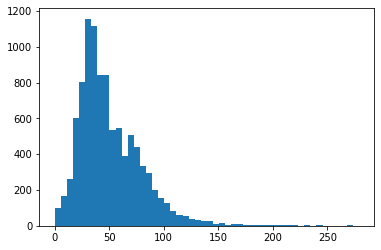

In [ ]:
plt.hist(edit_distance, bins = 50)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


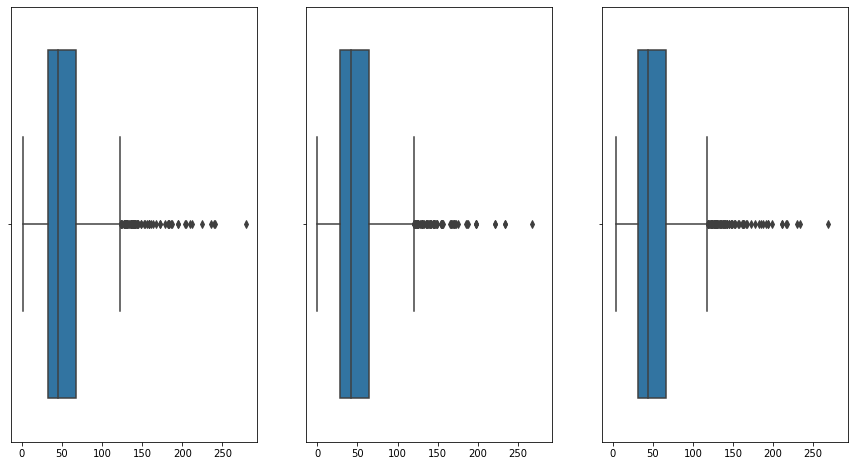

In [ ]:
lab = df['labels'].values
fig, axs = plt.subplots(1,len(np.unique(lab)) , figsize= (15,8), sharex= True)
for i, l in enumerate(np.unique(lab)):
  ii = (lab == l)
  sns.boxplot(edit_distance[ii], ax = axs[i])

In [ ]:
df['edit_distance'] = edit_distance

In [ ]:
df.head()

,sentence1,sentence2,labels,edit_distance
0,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,2,46.0
1,Two women are embracing while holding to go pa...,Two woman are holding packages.,1,23.0
2,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,0,34.0
3,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,1,119.0
4,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,2,126.0


In [ ]:
def create_dataset_for_dot(df, dct, func = 'sum', emb_dim = 300):
  dot_products = []
  #embedding_matrix = np.zeros((df.shape[0], 2*emb_dim))
  hit = 0
  miss = 0
  for i, (s1, s2) in enumerate(zip(df['sentence1'], df['sentence2'])):
    vec1 = []
    vec2 = []
    s1 = s1.lower()
    s2 = s2.lower()
    s1 = word_tokenize(s1)
    s2 = word_tokenize(s2)
    for w1, w2 in list(itertools.zip_longest(s1, s2, fillvalue='foo')):
      if w1 != "foo":
        check1 = dct.get(w1)
        if check1 is not None:
          vec1.append(check1)
          hit+=1
        else:
          miss+=1
        
      if w2 != "foo":
        check1 = dct.get(w2)
        if check1 is not None:
          vec2.append(check1)
          hit+=1
        else:
          miss+=1
    ##
    vec1 = np.asarray(vec1)
    vec2 = np.asarray(vec2)
    if func == "sum":
      vec1 = np.sum(vec1, axis = 0)
      vec2 = np.sum(vec2, axis = 0)
    if func == "mean":
      vec1 = np.mean(vec1, axis = 0)
      vec2 = np.mean(vec2, axis = 0)
    #print("vec1 ", vec1.shape, "vec2 shape ", vec2.shape, "i is ", i)
    #embedding_matrix[i, :] = np.concatenate((vec1, vec2))
    dot_products.append(np.dot(vec1, vec2))
  ##
  print(f"The number of hits are {hit} and the number of miss are {miss}")
  labels = df['labels'].values
  return dot_products, labels    

In [ ]:
def diff_sentences(df):
  diff = []
  for (s1, s2) in zip(df['sentence1'], df['sentence2']):
    s1 = word_tokenize(s1)
    s2 = word_tokenize(s2)
    np.abs(len(s1)- len(s2))
    diff.append(np.abs(len(s1)- len(s2)))
  return diff

In [ ]:
dct = Embedding_dict("/content/glove.6B.100d.txt")

Number of words found are 400000


In [ ]:
dot_prod, label = create_dataset_for_dot(df, dct, func= 'mean', emb_dim= 100)

The number of hits are 231113 and the number of miss are 550


In [ ]:
edit_distance = np.load("/content/drive/MyDrive/anlp_final/edit_dist.npy")

In [ ]:
diff = diff_sentences(df)

In [ ]:
df['edit_distance'] = edit_distance
df['dot_prod'] = dot_prod
df['diff'] = diff

In [ ]:
df.head()

,sentence1,sentence2,labels,edit_distance,dot_prod,diff
0,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,2,46.0,15.263969,5
1,Two women are embracing while holding to go pa...,Two woman are holding packages.,1,23.0,17.412409,4
2,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,0,34.0,16.280836,2
3,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,1,119.0,15.370991,25
4,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,2,126.0,16.407900,25


In [ ]:
df.iloc[:, 3:]

,edit_distance,dot_prod,diff
0,46.0,15.263969,5
1,23.0,17.412409,4
2,34.0,16.280836,2
3,119.0,15.370991,25
4,126.0,16.407900,25
...,...,...,...
9994,47.0,14.721049,8
9996,41.0,16.556662,3
9997,130.0,16.469961,28
9998,127.0,13.714272,27


In [ ]:
X = df.iloc[:, 3:].values
y = df.iloc[:, 2].values

In [ ]:
xtr = X[:8000, :]
xte = X[8000:, :]
ytr = y[:8000]
yte = y[8000:]

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = SVC()
clf.fit(xtr, ytr)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf.score(xte, yte)

0.4218241042345277

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

In [ ]:
clf.fit(xtr, ytr)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
clf.score(xte, yte)

0.38219326818675353

In [ ]:
type(dot_prod)

list

In [ ]:
ii = label == 0
for_0 = np.array(dot_prod)[ii]
ii = label == 1
for_1 = np.array(dot_prod)[ii]
ii = label == 2
for_2 = np.array(dot_prod)[ii]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

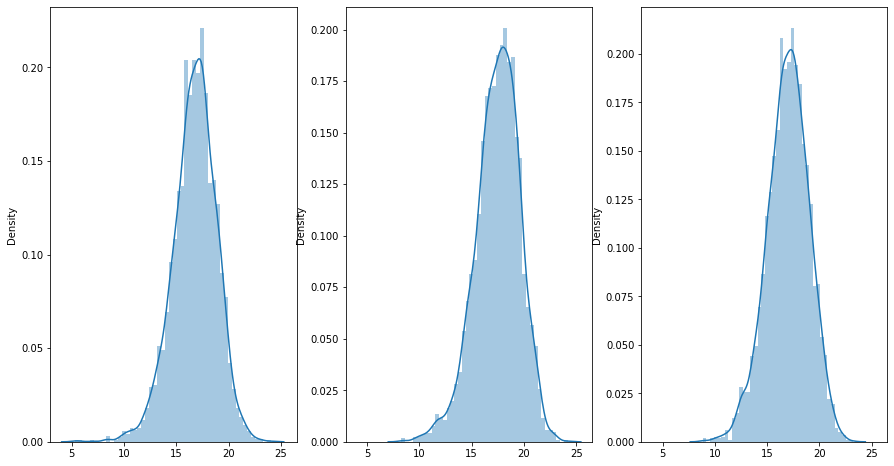

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (15,8), sharex= True)
sns.distplot(for_0, ax = axs[0])
sns.distplot(for_1, ax = axs[1])
sns.distplot(for_2, ax = axs[2])

In [ ]:
classes_names

array(['contradiction', 'entailment', 'neutral'], dtype=object)

In [ ]:
ii = label == 0
for_0 = np.array(diff)[ii]
ii = label == 1
for_1 = np.array(diff)[ii]
ii = label == 2
for_2 = np.array(diff)[ii]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

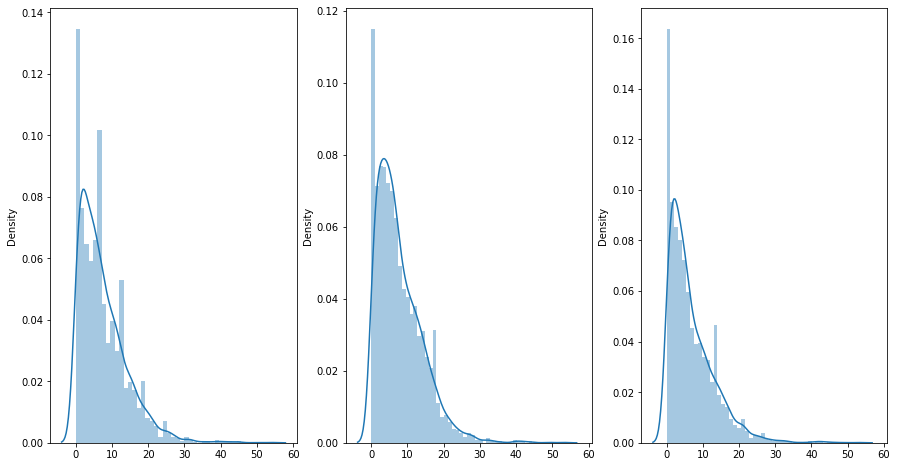

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (15,8), sharex= True)
sns.distplot(for_0, ax = axs[0])
sns.distplot(for_1, ax = axs[1])
sns.distplot(for_2, ax = axs[2])

In [ ]:
df.head()

,sentence1,sentence2,labels,edit_distance,dot_prod,diff
0,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,2,46.0,15.263969,5
1,Two women are embracing while holding to go pa...,Two woman are holding packages.,1,23.0,17.412409,4
2,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,0,34.0,16.280836,2
3,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,1,119.0,15.370991,25
4,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,2,126.0,16.407900,25


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
norm = scaler.fit_transform(xtr)

In [ ]:
norm_test = scaler.fit_transform(xte)

In [ ]:
clf = SVC()
clf.fit(norm, ytr)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf.score(norm_test, yte)

0.43593919652551577